In [1]:
import torch
from transformers import ViltProcessor, ViltForImagesAndTextClassification
import requests
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 二分类 True False

In [3]:
version = "dandelin/vilt-b32-finetuned-nlvr2"
image1 = Image.open(
    requests.get("https://lil.nlp.cornell.edu/nlvr/exs/ex0_0.jpg", stream=True).raw
).convert("RGB")
image2 = Image.open(
    requests.get("https://lil.nlp.cornell.edu/nlvr/exs/ex0_1.jpg", stream=True).raw
).convert("RGB")
text = "The left image contains twice the number of dogs as the right image."

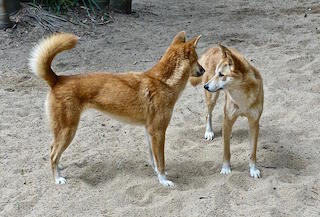

In [4]:
image1

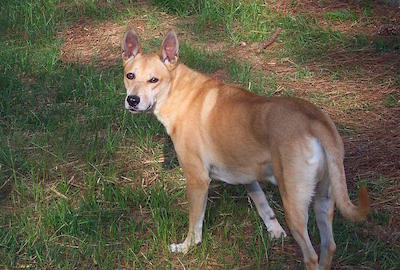

In [5]:
image2

# ViltProcessor

In [6]:
processor: ViltProcessor = ViltProcessor.from_pretrained(version)
processor

ViltProcessor:
- image_processor: ViltImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViltFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViltImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 384
  },
  "size_divisor": 32
}

- tokenizer: BertTokenizerFast(name_or_path='dandelin/vilt-b32-finetuned-nlvr2', vocab_size=30522, model_max_length=40, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

## processor

In [7]:
inputs = processor(
    text=text,  # 可以为列表或单个string
    images=[image1, image2],  # 可以为列表或单张图片
    return_tensors="pt",  # 返回数据格式 np pt tf jax
).to(device, torch.float16)
inputs

{'input_ids': tensor([[ 101, 1996, 2187, 3746, 3397, 3807, 1996, 2193, 1997, 6077, 2004, 1996,
         2157, 3746, 1012,  102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[[[-0.1137, -0.1451, -0.2000,  ...,  0.1529,  0.2000,  0.2235],
          [-0.1137, -0.1451, -0.2000,  ...,  0.0745,  0.0902,  0.1059],
          [-0.1216, -0.1529, -0.2078,  ..., -0.0667, -0.0745, -0.0745],
          ...,
          [ 0.5608,  0.4902,  0.3647,  ...,  0.4353,  0.4667,  0.4745],
          [ 0.6392,  0.5922,  0.5216,  ...,  0.4745,  0.4980,  0.5059],
          [ 0.6706,  0.6549,  0.6235,  ...,  0.4902,  0.4980,  0.5059]],

         [[-0.0824, -0.1137, -0.1843,  ...,  0.1686,  0.2157,  0.2392],
          [-0.0824, -0.1137, -0.1843,  ...,  0.0902,  0.1059,  0.1216],
          [-0.0902, -0.1216, -0.1922,  ..., -0.0510, 

In [8]:
inputs["input_ids"]

tensor([[ 101, 1996, 2187, 3746, 3397, 3807, 1996, 2193, 1997, 6077, 2004, 1996,
         2157, 3746, 1012,  102]], device='cuda:0')

In [9]:
inputs["pixel_values"].shape

torch.Size([2, 3, 384, 544])

# ViltForImagesAndTextClassification 文本二分类

In [10]:
model: ViltForImagesAndTextClassification = (
    ViltForImagesAndTextClassification.from_pretrained(
        version, torch_dtype=torch.float16
    ).to(device)
)
model

ViltForImagesAndTextClassification(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(3, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_f

In [11]:
model.eval()
with torch.inference_mode():
    outputs = model(
        input_ids=inputs.input_ids, pixel_values=inputs.pixel_values.unsqueeze(0)
    )
outputs

ViltForImagesAndTextClassificationOutput(loss=None, logits=tensor([[-2.0967,  2.6940]], device='cuda:0'), hidden_states=None, attentions=None)

In [16]:
print(len(model.config.id2label))
print(model.config.id2label)

2
{0: 'False', 1: 'True'}


In [13]:
logits = outputs["logits"]
print(logits.shape)  # [2] 代表 False True
logits

torch.Size([1, 2])


tensor([[-2.0967,  2.6940]], device='cuda:0')

In [14]:
idx = logits.argmax(-1).item()
idx

1

In [15]:
print(f"{text} answer:", model.config.id2label[idx])

The left image contains twice the number of dogs as the right image. answer: True
